In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.notebook import tqdm
import pandas as pd
import random
%matplotlib inline

from networkx.algorithms import community as com


plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 22
sns.set_style("whitegrid") 

# Контрольная работа (16 баллов)

## Оптимизация модулярности (теория) (4 балла)

Рассмотрим граф-цикл $C_N$ на $N$ вершинах: каждая вершина имеет ровно две связи с соседними вершинами, расположенными на окружности (ниже пример для $N=10$). Рассмотрим разделение графа на $k$ последовательных сообществ, размера $n=N/k$:  т.е. сообщества формируют вершины соседствующие на окружности (см. Рисунок). Определите оптимальные размер кластера и число кластеров на графе, считая что оптимальное разбиение соответвует максимальной модулярности. Для простоты считайте, что $n$ целое.

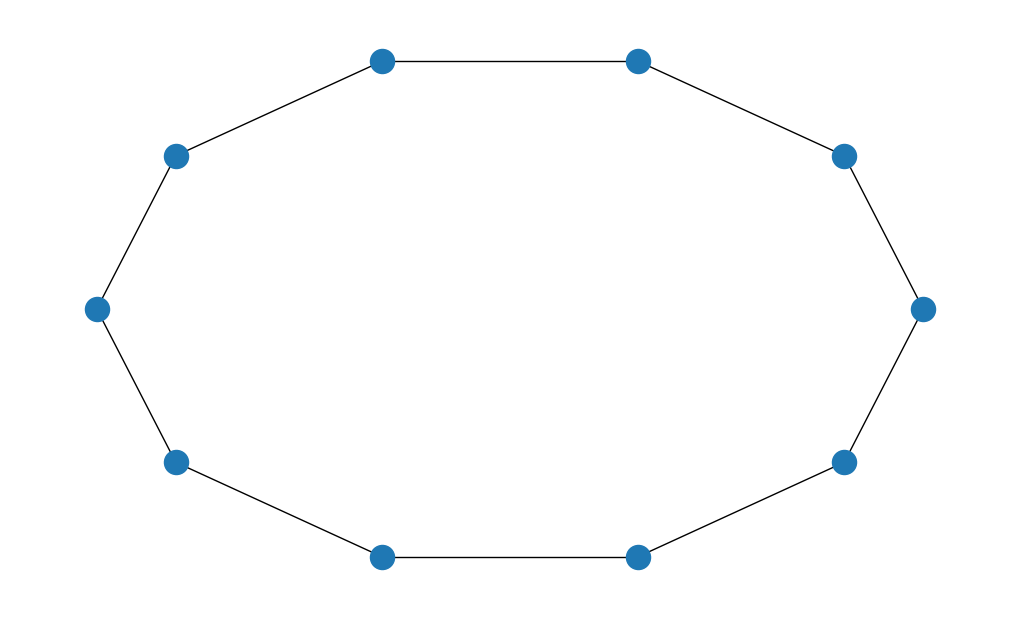

In [2]:
N=10 # граф-цикл
C=nx.cycle_graph(N)
pos = nx.circular_layout(C)
nx.draw(C,pos)

Пример разбиения: ![picture](https://drive.google.com/uc?export=view&id=1Qf04ns4C7q1v9831gSubZAwbYcZtz6-m)

Модулярность - функционал, определяющий оптимальность разбиения сети на сообщества:
$$
M=\frac{1}{2L}\sum_{i,j}^N\left(A_{ij}-\frac{k_ik_j}{2L}\right)\delta_{C_i,C_j},
$$

$L$ - число ребер в сети, $A$ - матрица смежности, $k_i$ - степень вершины $i$, $C_i$ - метка вершины $i$, определяющая принадлежность к сообществу, т.е.
$\delta_{C_i,C_j} = 1$, если $i$ и $j$ относятся к одному сообществу, иначе $\delta_{C_i,C_j} = 0$.




$$
M=\sum_{i,j}^NM_c
$$

$$
M_c=\frac{L_c}{L}\ - (\frac{K_c}{2L})^{2}
$$

$$
K_c = 2L_c
$$

$$
M_c=\frac{L_c}{L}\ - (\frac{L_c}{L})^{2}
$$

Функция вида:
$$
y = x - x^{2}
$$

Максимум достигается при: 
$$
x = 0.5 ->  L_c = L * 0.5 -> L_c = 5 
$$  

**5 - оптимальный размер кластера**  
**2 - оптимальное кол-во кластеров**

In [3]:
def optimal_cluster_size_and_number(graph):
    """
    Рассчитываем в python
    """
    N = len(graph.nodes())
    max_modularity = -1
    optimal_cluster_size = 0
    optimal_num_clusters = 0
    
    for k in range(1, N + 1):
        if N % k == 0:  # удостоверяемся, что размер кластера является целым числом
            n = N // k
            communities = [list(range(i * n, (i + 1) * n)) for i in range(k)]
            modularity = nx.community.quality.modularity(graph, communities)
            
            if modularity > max_modularity:
                max_modularity = modularity
                optimal_cluster_size = n
                optimal_num_clusters = k
    
    return optimal_cluster_size, optimal_num_clusters

optimal_size, optimal_num = optimal_cluster_size_and_number(C)
print("Optimal Cluster Size:", optimal_size)
print("Optimal Number of Clusters:", optimal_num)

Optimal Cluster Size: 5
Optimal Number of Clusters: 2


## Моделирование случайно-геометрического графа (12 баллов)

Рассмотрим следующую модель построения графа. Сначала случайно разместим N вершин в некотором метрическом пространстве размерности $d$ (согласно к заданному распределению вероятности), далее соединим две вершины ребром тогда и только тогда, когда расстояние между ними  меньше определенного радиуса $r$.
В NetworkX есть соответствующий [генератор](https://networkx.org/documentation/stable/reference/generated/networkx.generators.geometric.random_geometric_graph.html).

In [4]:
rgG = nx.random_geometric_graph(1000, 0.2, dim=3)


print(rgG.number_of_nodes(), rgG.number_of_edges())

1000 13213


1. Постройте зависимости плотности, кластеризации и размер наибольшей связанной компоненты графа от параметра $r$. Объясните полученные результаты. (3 балла)

2. Выберите параметры так, чтобы средняя степень графа была $<k>=5$. Исследуйте структурные свойства графа: распределение степеней, распределение коэффициентов кластеризации. Определите сообщества (количество сообществ и распределение размеров сообществ), модулярность сети. Алгоритм поиска сообществ выберите на свое усмотрение. (6 баллов)

3. С помощью библиотеки NDlib смоделируйте SIR модель на графе. Подберите параметры $\beta$, $\gamma$ таким образом, чтобы характерное число итераций, за которое доля вершин в состоянии R становится равной 1 было около 100.
Сравните зависимости $I(t), R(t)$ для геометрического графа со случайным графов Эрдеша-Реньи той же плотности. (3 балла)

#### Постройте зависимости плотности, кластеризации и размер наибольшей связанной компоненты графа от параметра $r$. Объясните полученные результаты. (3 балла)

  0%|          | 0/20 [00:00<?, ?it/s]

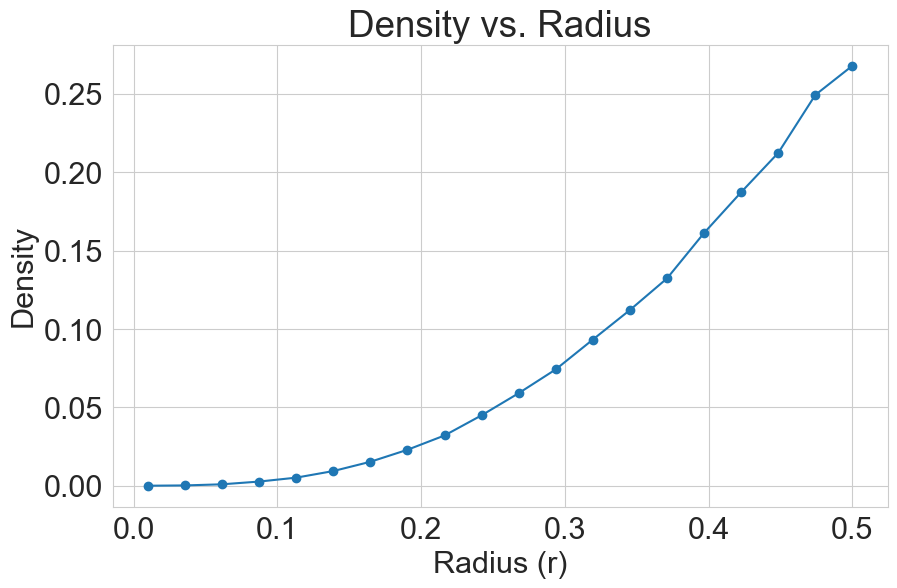

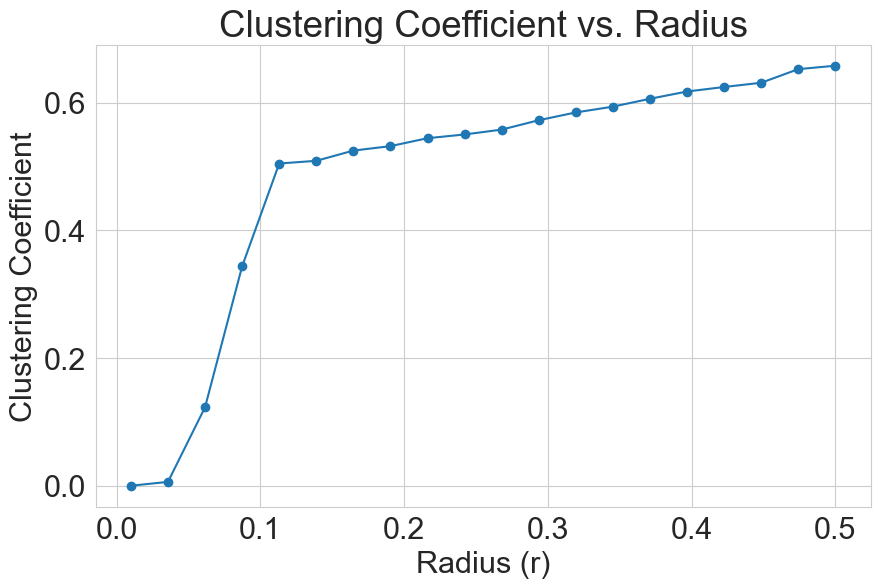

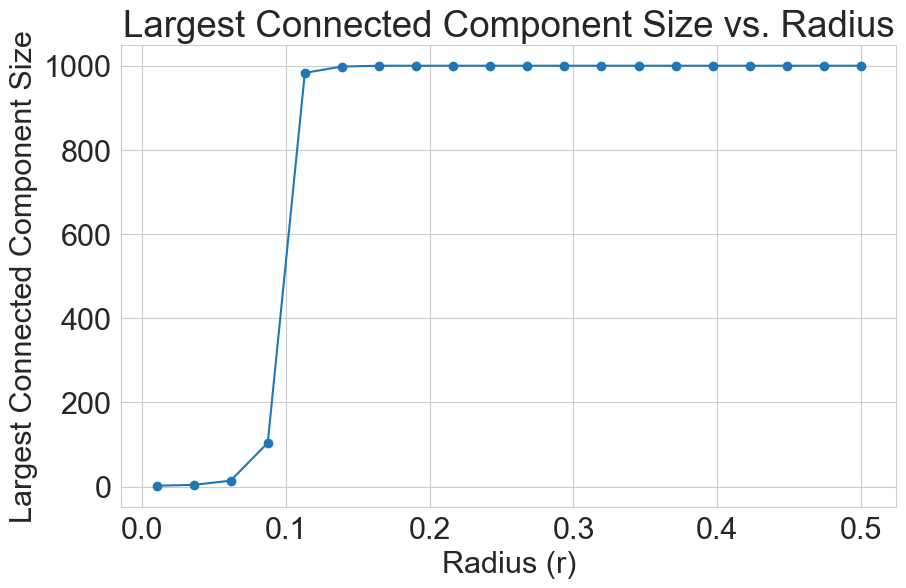

In [5]:
# Функция для вычисления плотности графа
def calculate_density(graph):
    n = len(graph.nodes)
    m = len(graph.edges)
    return 2 * m / (n * (n - 1))

# Функция для вычисления коэффициента кластеризации графа
def calculate_clustering_coefficient(graph):
    return nx.average_clustering(graph)

# Функция для вычисления размера наибольшей связанной компоненты
def calculate_largest_connected_component_size(graph):
    return len(max(nx.connected_components(graph), key=len))

# Задаем диапазон значений параметра r
r_values = np.linspace(0.01, 0.5, 20)

# Создаем списки для хранения плотности, коэффициента кластеризации и размера наибольшей связанной компоненты
density_values, clustering_coefficient_values, largest_connected_component_size_values  = [], [], []

# Генерируем графы и вычисляем характеристики для каждого значения параметра r
for r in tqdm(r_values):
    rgG = nx.random_geometric_graph(1000, r, dim=3)
    density_values.append(calculate_density(rgG))
    clustering_coefficient_values.append(calculate_clustering_coefficient(rgG))
    largest_connected_component_size_values.append(calculate_largest_connected_component_size(rgG))

# Строим графики зависимости плотности, коэффициента кластеризации и размера наибольшей связанной компоненты от параметра r
plt.plot(r_values, density_values, marker='o')
plt.xlabel('Radius (r)')
plt.ylabel('Density')
plt.title('Density vs. Radius')
plt.show()

plt.plot(r_values, clustering_coefficient_values, marker='o')
plt.xlabel('Radius (r)')
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient vs. Radius')
plt.show()

plt.plot(r_values, largest_connected_component_size_values, marker='o')
plt.xlabel('Radius (r)')
plt.ylabel('Largest Connected Component Size')
plt.title('Largest Connected Component Size vs. Radius')
plt.show()


## Выводы:

**Зависимость плотности от параметра 𝑟:**

При малых значениях параметра 𝑟 граф будет иметь низкую плотность, так как расстояние между вершинами будет большим, и вероятность создания ребра между ними будет невелика.
При увеличении значения параметра 𝑟 граф будет становиться более плотным, так как расстояние между вершинами станет меньше, что приведёт к большему количеству рёбер.

**Зависимость коэффициента кластеризации от параметра 𝑟:**

При малых значениях параметра 𝑟 граф будет иметь низкий коэффициент кластеризации, так как вершины будут иметь мало соседей и образование треугольников будет редким.
При увеличении значения параметра 𝑟 граф будет становиться более плотным, что может способствовать образованию кластеров, увеличивая коэффициент кластеризации.

**Зависимость размера наибольшей связанной компоненты от параметра 𝑟:**

При малых значениях параметра 𝑟 граф может быть разреженным, что может привести к тому, что наибольшая связанная компонента будет относительно мала.
При увеличении значения параметра 𝑟 граф становится более плотным, и вероятность того, что большая часть графа будет связана, увеличивается, что приводит к увеличению размера наибольшей связанной компоненты.

#### Выберите параметры так, чтобы средняя степень графа была $<k>=5$. Исследуйте структурные свойства графа: распределение степеней, распределение коэффициентов кластеризации. Определите сообщества (количество сообществ и распределение размеров сообществ), модулярность сети. Алгоритм поиска сообществ выберите на свое усмотрение. (6 баллов)

In [6]:
from community import community_louvain # pip install python-louvain
from collections import Counter

In [7]:
G = nx.random_geometric_graph(1000, 0.11111, dim=3) # подбирал эмперически
avg_degree = np.mean([d for n, d in G.degree()])
print("Средняя степень графа: ", avg_degree)

Средняя степень графа:  5.148


Средняя степень графа:  5.074


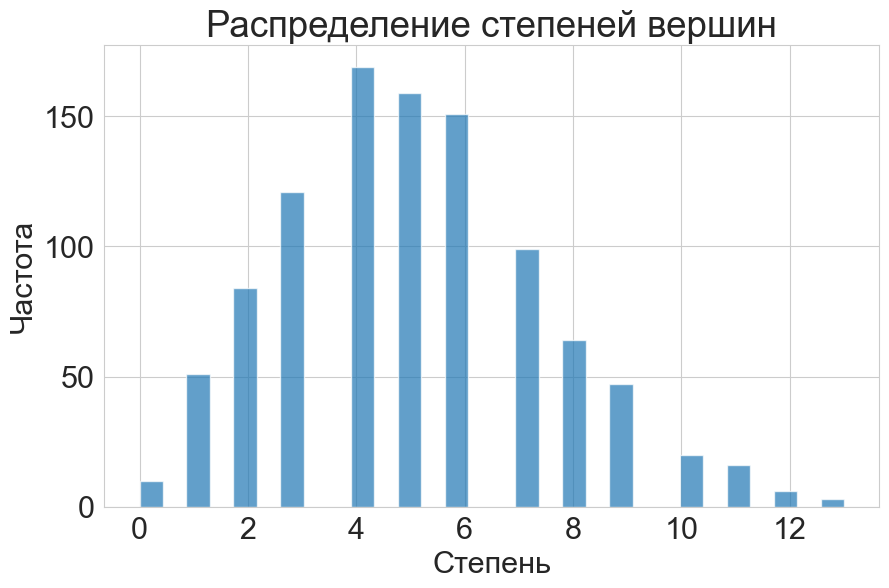

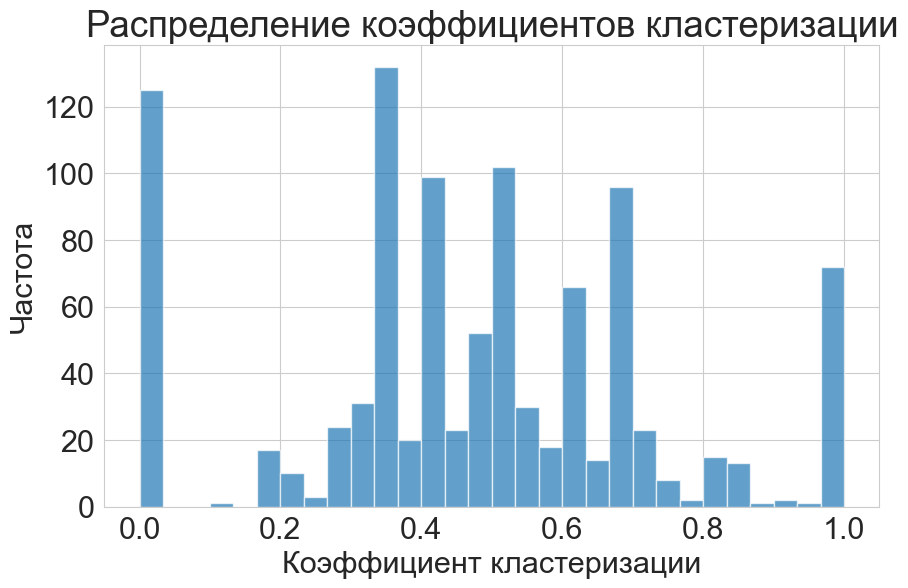

Количество сообществ: 42


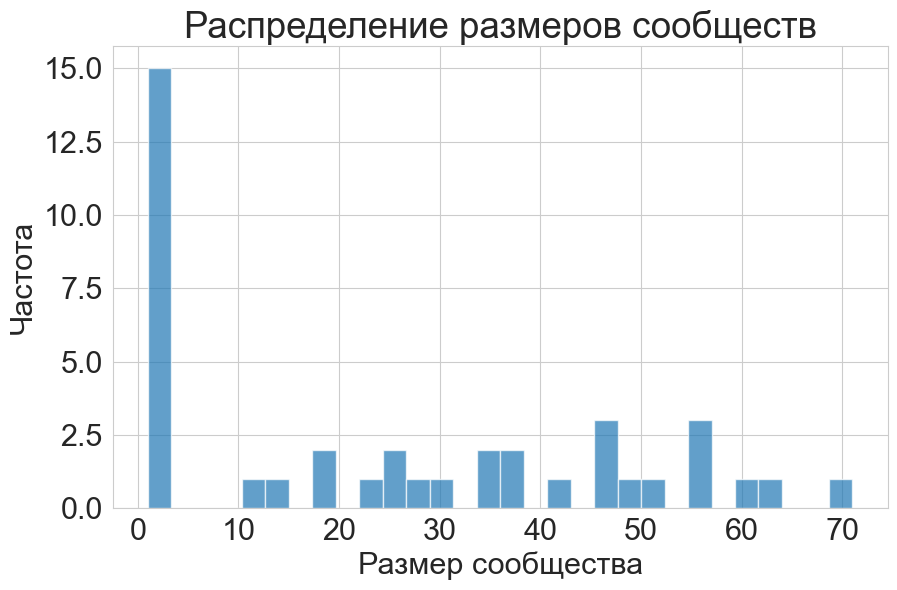

In [8]:
# Генерируем граф
G = nx.random_geometric_graph(1000, 0.11111, dim=3)

# Вывод средней степени графа
avg_degree = np.mean([d for n, d in G.degree()])
print("Средняя степень графа: ", avg_degree)

# Визуализация распределения степеней вершин
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.hist(degree_sequence, bins=30, alpha=0.7)
plt.title("Распределение степеней вершин")
plt.xlabel("Степень")
plt.ylabel("Частота")
plt.show()

# Визуализация распределения коэффициентов кластеризации вершин
clustering_coefficients = nx.clustering(G)
plt.hist(list(clustering_coefficients.values()), bins=30, alpha=0.7)
plt.title("Распределение коэффициентов кластеризации")
plt.xlabel("Коэффициент кластеризации")
plt.ylabel("Частота")
plt.show()

# Поиск сообществ алгоритмом Лювейна

communities = list(community_louvain.best_partition(G).values())
unique_communities = set(community_louvain.best_partition(G).values())

num_communities = len(unique_communities)
print("Количество сообществ:", num_communities)

# Распределение размеров сообществ

plt.hist(Counter(communities).values(), bins=30, alpha=0.7)
plt.title("Распределение размеров сообществ")
plt.xlabel("Размер сообщества")
plt.ylabel("Частота")
plt.show()

**Модулярность**

In [9]:
community_louvain_origin = community_louvain.best_partition(G)

coms_for_modularity = []
for i in range(max(community_louvain_origin.values())+1):
    coms_for_modularity.append(set(n for n in G.nodes() if (community_louvain_origin[n]==i)))
modularity = nx.community.modularity(G, coms_for_modularity)
print("Модулярность сети:", round(modularity, 3))

Модулярность сети: 0.886


#### С помощью библиотеки NDlib смоделируйте SIR модель на графе. Подберите параметры  𝛽,  𝛾 таким образом, чтобы характерное число итераций, за которое доля вершин в состоянии R становится равной 1 было около 100. Сравните зависимости  𝐼(𝑡),𝑅(𝑡) для геометрического графа со случайным графов Эрдеша-Реньи той же плотности. (3 балла)

In [10]:
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

**Геометрический граф**

𝛽: 0.1 𝛾: 0.01


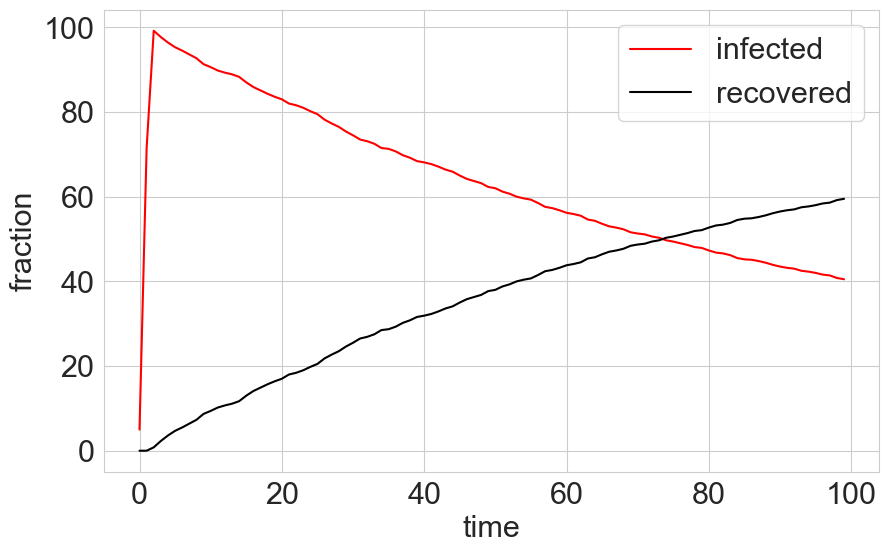

𝛽: 0.1 𝛾: 0.03


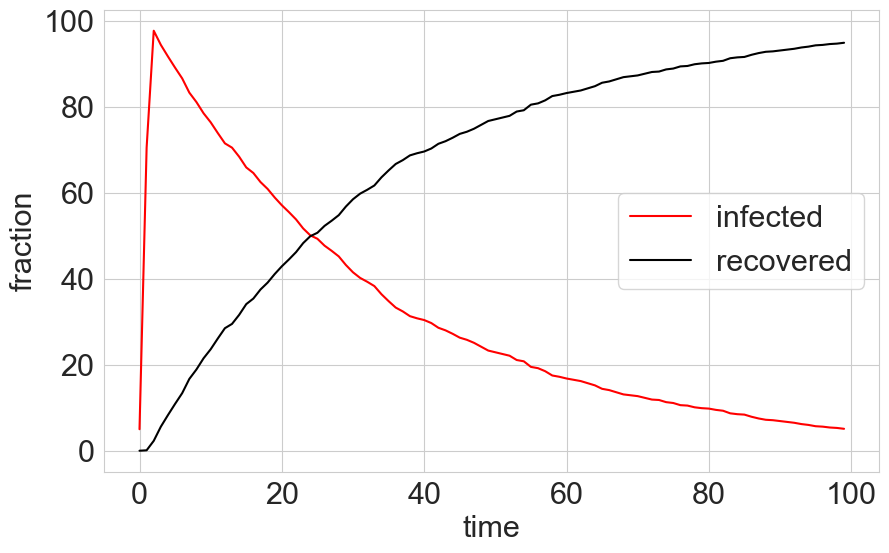

𝛽: 0.1 𝛾: 0.05


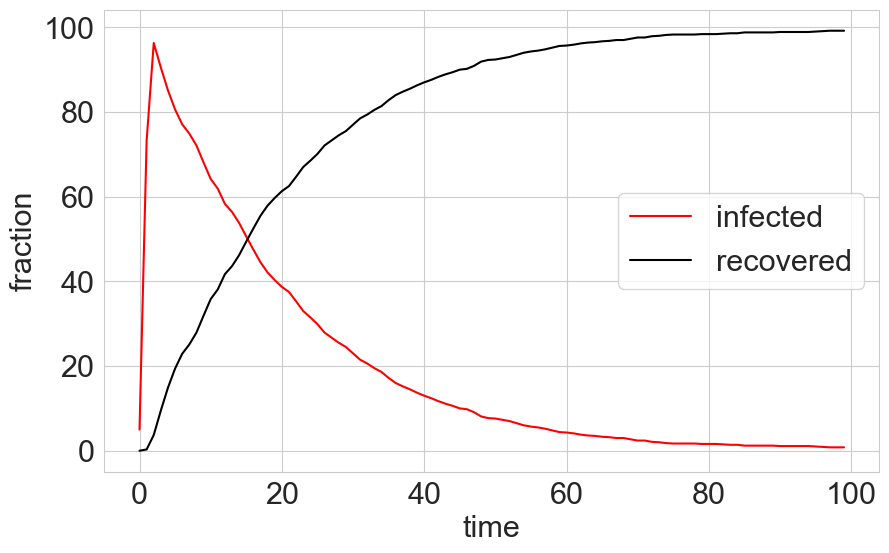

𝛽: 0.3 𝛾: 0.01


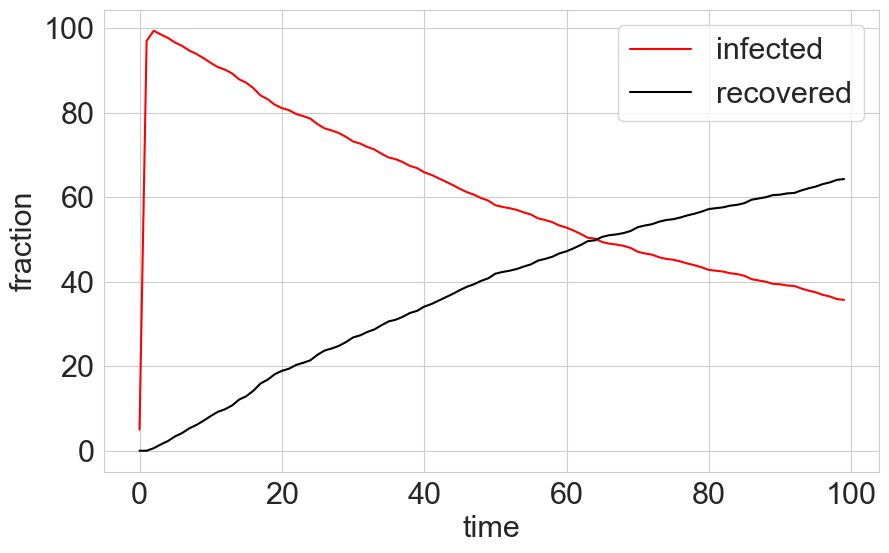

𝛽: 0.3 𝛾: 0.03


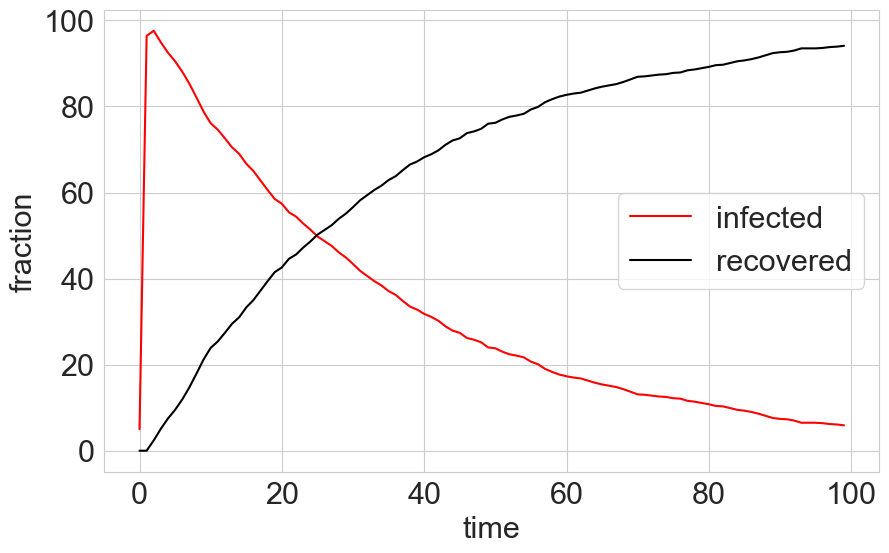

𝛽: 0.3 𝛾: 0.05


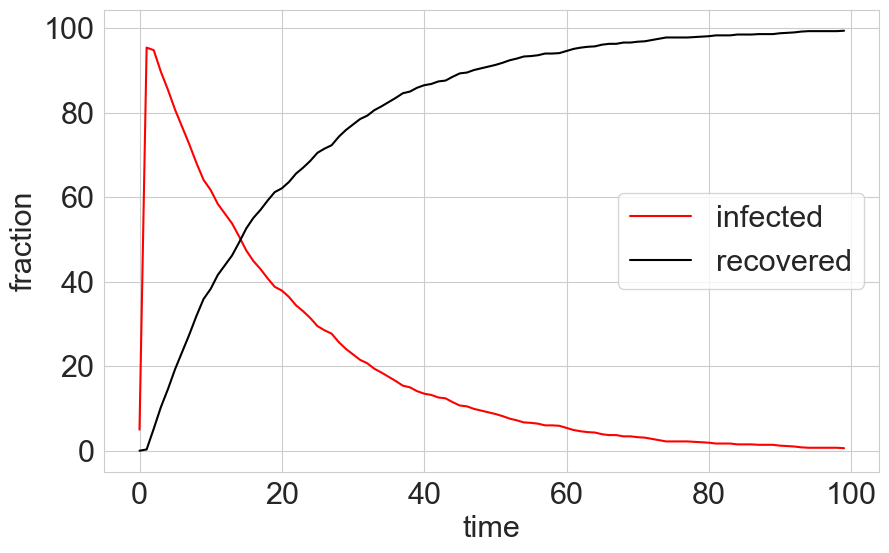

𝛽: 0.6 𝛾: 0.01


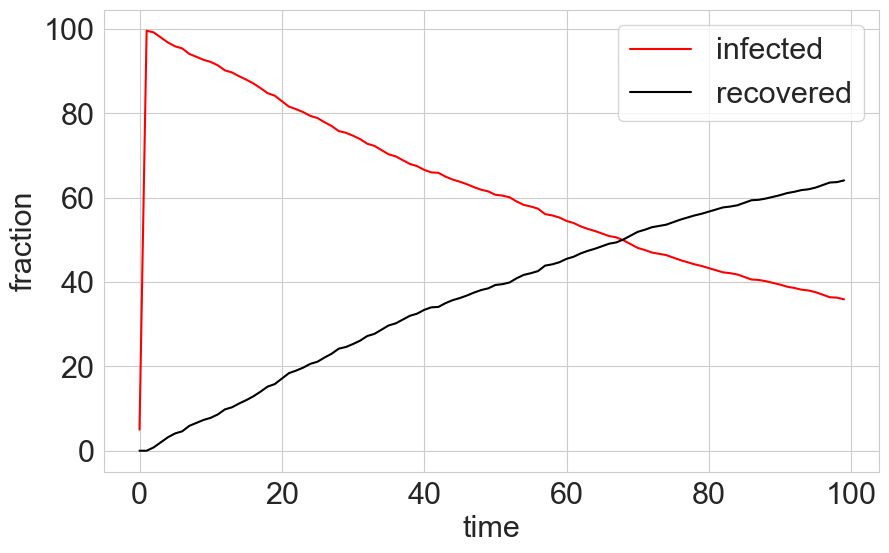

𝛽: 0.6 𝛾: 0.03


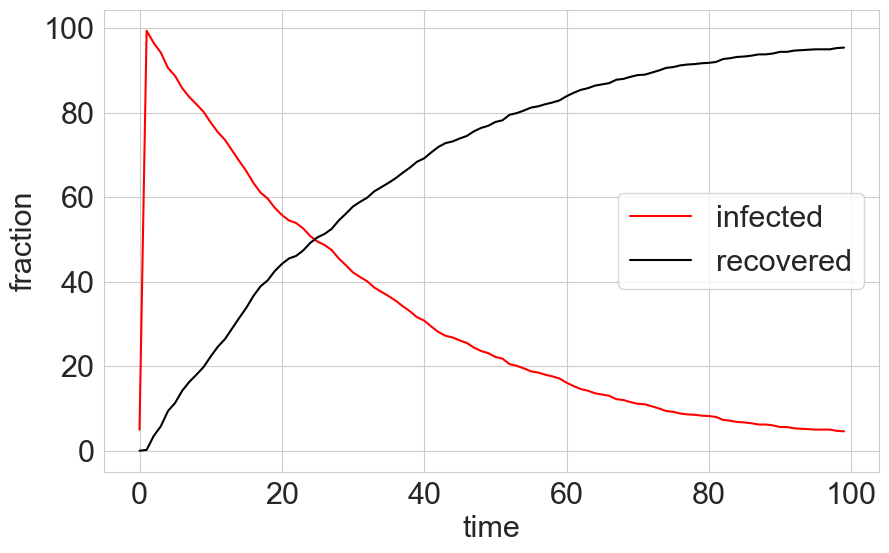

𝛽: 0.6 𝛾: 0.05


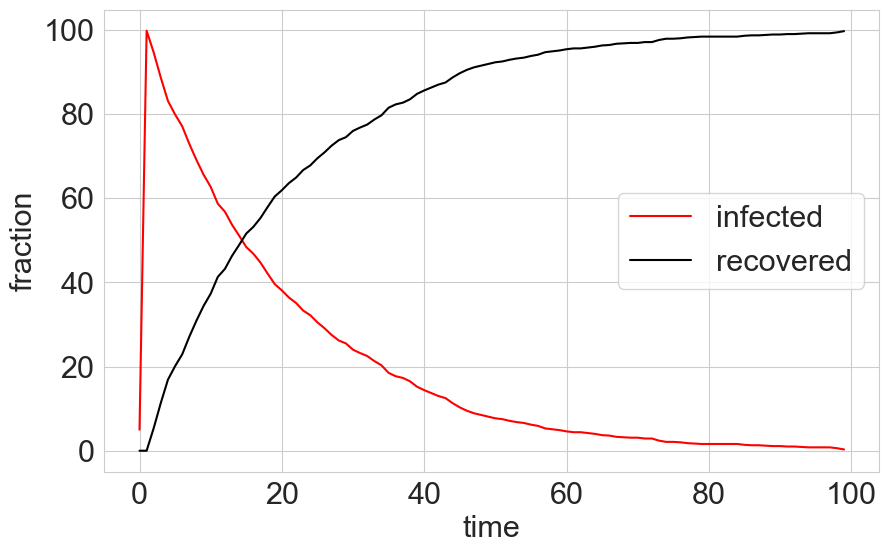

In [11]:
betas = [0.1, 0.3, 0.6]
gammas = [0.01, 0.03, 0.05]

for beta in betas:
    for gamma in gammas:
        sir_model = ep.SIRModel(rgG) # пример из семинара 06
        config = mc.Configuration()
        config.add_model_parameter('beta', beta) # эти параметры нужно подобрать
        config.add_model_parameter('gamma',gamma)
        config.add_model_parameter("percentage_infected", 0.05)
        sir_model.set_initial_status(config)
        iterations = sir_model.iteration_bunch(100)
        susceptible,infected,recovered = [],[],[]

        for iteration in iterations:
            node_count = iteration['node_count']
            susceptible.append(node_count[0]/N)
            infected.append(node_count[1]/N)
            recovered.append(node_count[2]/N)
        
        print(f"𝛽: {beta}", f"𝛾: {gamma}")
        plt.plot(infected,color='r',label='infected')
        plt.plot(recovered, color='k',label='recovered')
        plt.xlabel('time')
        plt.ylabel('fraction')
        plt.legend()
        plt.show()

Выбираем параметры

**𝛽: 0.1 𝛾: 0.05**

**Эрдеша-Реньи**

In [12]:
rgG_density = nx.density(rgG)

print("Плотность геометрического графа:", rgG_density)

Плотность геометрического графа: 0.2678858858858859


In [13]:
erdos_renyi_graph = nx.erdos_renyi_graph(n=1000, p=rgG_density)

print("Плотность графа Эрдеша-Реньи:", nx.density(erdos_renyi_graph))

Плотность графа Эрдеша-Реньи: 0.26781981981981984


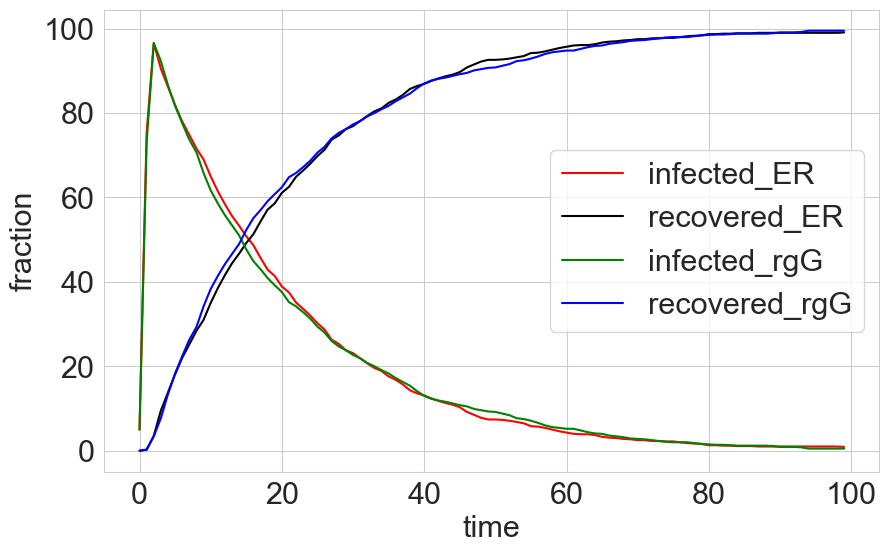

In [14]:
beta = 0.1
gamma = 0.05


sir_model = ep.SIRModel(erdos_renyi_graph) # пример из семинара 06
config = mc.Configuration()
config.add_model_parameter('beta', beta) # эти параметры нужно подобрать
config.add_model_parameter('gamma',gamma)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)
iterations = sir_model.iteration_bunch(100)
susceptible,infected,recovered = [],[],[]

for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)
    recovered.append(node_count[2]/N)
        
plt.plot(infected,color='r',label='infected_ER')
plt.plot(recovered, color='k',label='recovered_ER')
plt.xlabel('time')
plt.ylabel('fraction')


sir_model = ep.SIRModel(rgG) # пример из семинара 06
config = mc.Configuration()
config.add_model_parameter('beta', beta) # эти параметры нужно подобрать
config.add_model_parameter('gamma',gamma)
config.add_model_parameter("percentage_infected", 0.05)
sir_model.set_initial_status(config)
iterations = sir_model.iteration_bunch(100)
susceptible,infected,recovered = [],[],[]

for iteration in iterations:
    node_count = iteration['node_count']
    susceptible.append(node_count[0]/N)
    infected.append(node_count[1]/N)
    recovered.append(node_count[2]/N)
    
plt.plot(infected,color='g',label='infected_rgG')
plt.plot(recovered, color='b',label='recovered_rgG')
plt.xlabel('time')
plt.ylabel('fraction')


plt.legend()
plt.show()

**Графики для Эрдеша-Реньи и геометрического графа практически совпадают**